# Worked Examples:
## Hu Liu - INFO7390 - 2025Spring

### First Worked Example: Student Performance Dataset

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.neighbors import NearestNeighbors
import networkx as nx

# Set random seed for reproducibility
np.random.seed(42)

# Load the student dataset
# Assuming the file is in the current directory
student_df = pd.read_csv('student-mat.csv', sep=';')

# Display basic information about the dataset
print("Dataset Information:")
print(f"Number of samples: {student_df.shape[0]}")
print(f"Number of features: {student_df.shape[1]}")
print("\nFeatures:")
print(student_df.columns.tolist())

# Display the first few rows of the dataset
student_df.head()

Dataset Information:
Number of samples: 395
Number of features: 33

Features:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


Missing values per column:
school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

Basic statistics of numeric columns:
              age        Medu        Fedu  traveltime   studytime    failures  \
count  395.000000  395.000000  395.000000  395.000000  395.000000  395.000000   
mean    16.696203    2.749367    2.521519    1.448101    2.035443    0.334177   
std      1.276043    1.094735    1.088201    0.697505    0.839240    0.743651   
min     15.000000    0.000000    0.000000    1.000000    1.000000    0

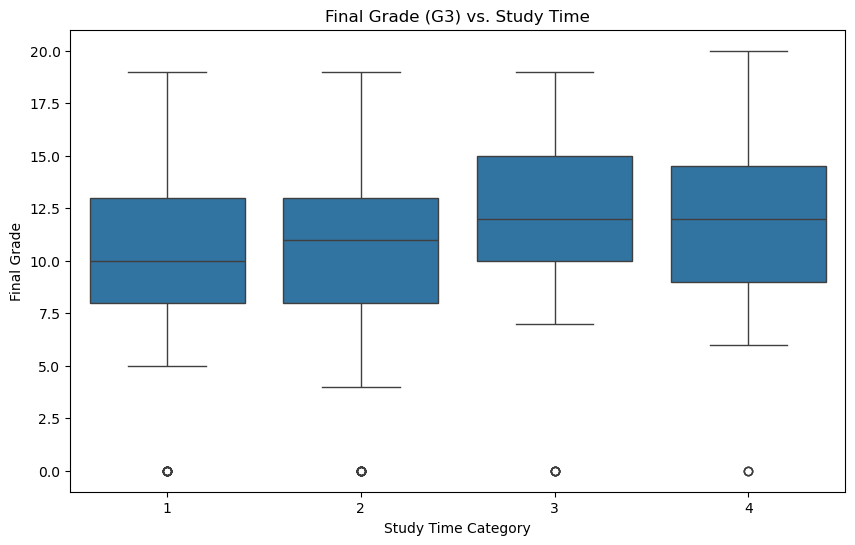


Correlation between studytime and G3: 0.0978


In [7]:
# Check for missing values
print("Missing values per column:")
print(student_df.isnull().sum())

# Basic statistics of numeric columns
print("\nBasic statistics of numeric columns:")
print(student_df.describe())

# Let's focus on our key variables: studytime and G3 (final grade)
print("\nUnique values for studytime:")
print(student_df['studytime'].value_counts())
print("\nStudytime description:")
print("1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours")

# Visualize the relationship between studytime and final grade (G3)
plt.figure(figsize=(10, 6))
sns.boxplot(x='studytime', y='G3', data=student_df)
plt.title('Final Grade (G3) vs. Study Time')
plt.xlabel('Study Time Category')
plt.ylabel('Final Grade')
plt.show()

# Correlation between studytime and G3
correlation = student_df['studytime'].corr(student_df['G3'])
print(f"\nCorrelation between studytime and G3: {correlation:.4f}")

In [11]:
# 1. Simple Linear Regression (Association, not causation)
X = student_df[['studytime']]
y = student_df['G3']
model = LinearRegression().fit(X, y)
print("Linear Regression Results:")
print(f"Coefficient for studytime: {model.coef_[0]:.4f}")
print(f"Intercept: {model.intercept_:.4f}")
print(f"R² score: {model.score(X, y):.4f}")

# 2. Multiple Regression with Potential Confounders
# Select potential confounding variables
confounders = ['age', 'famrel', 'freetime', 'goout', 'health', 'absences']
X_with_confounders = student_df[['studytime'] + confounders]
model_with_confounders = LinearRegression().fit(X_with_confounders, y)
print("\nMultiple Regression Results with Confounders:")
print(f"Coefficient for studytime: {model_with_confounders.coef_[0]:.4f}")
print(f"R² score: {model_with_confounders.score(X_with_confounders, y):.4f}")

# 3. Propensity Score Analysis
# For this example, we'll convert studytime to a binary variable (high vs low)
student_df['high_studytime'] = (student_df['studytime'] >= 3).astype(int)

# Potential confounders for propensity score model
ps_model = smf.logit("high_studytime ~ age + famrel + freetime + goout + health + absences", 
                     data=student_df).fit(disp=False)

# Calculate propensity scores
student_df['propensity_score'] = ps_model.predict()

# Stratify based on propensity scores
student_df['ps_quintile'] = pd.qcut(student_df['propensity_score'], 5, labels=False)

# Calculate average treatment effect within each stratum
ate_by_stratum = []
for stratum in range(5):
    stratum_df = student_df[student_df['ps_quintile'] == stratum]
    effect = stratum_df[stratum_df['high_studytime'] == 1]['G3'].mean() - \
             stratum_df[stratum_df['high_studytime'] == 0]['G3'].mean()
    ate_by_stratum.append(effect)

# Calculate overall average treatment effect
ate = np.mean(ate_by_stratum)
print("\nPropensity Score Analysis:")
print(f"Average Treatment Effect (ATE) of high study time on final grade: {ate:.4f}")

Linear Regression Results:
Coefficient for studytime: 0.5340
Intercept: 9.3283
R² score: 0.0096

Multiple Regression Results with Confounders:
Coefficient for studytime: 0.5177
R² score: 0.0654

Propensity Score Analysis:
Average Treatment Effect (ATE) of high study time on final grade: 1.3609


In [13]:
# 4. Matching Analysis using Nearest Neighbors
# Standardize confounding variables
scaler = StandardScaler()
confounders_scaled = scaler.fit_transform(student_df[confounders])

# Find matches for treated units (high_studytime = 1)
treated = student_df[student_df['high_studytime'] == 1]
control = student_df[student_df['high_studytime'] == 0]

# Use NearestNeighbors to find matches
nn = NearestNeighbors(n_neighbors=1)
nn.fit(scaler.transform(control[confounders]))
distances, indices = nn.kneighbors(scaler.transform(treated[confounders]))

# Get matched control units
matched_control = control.iloc[indices.flatten()]

# Calculate treatment effect
matched_effect = treated['G3'].mean() - matched_control['G3'].mean()
print("\nMatching Analysis:")
print(f"Treatment effect from matched samples: {matched_effect:.4f}")


Matching Analysis:
Treatment effect from matched samples: 1.2717


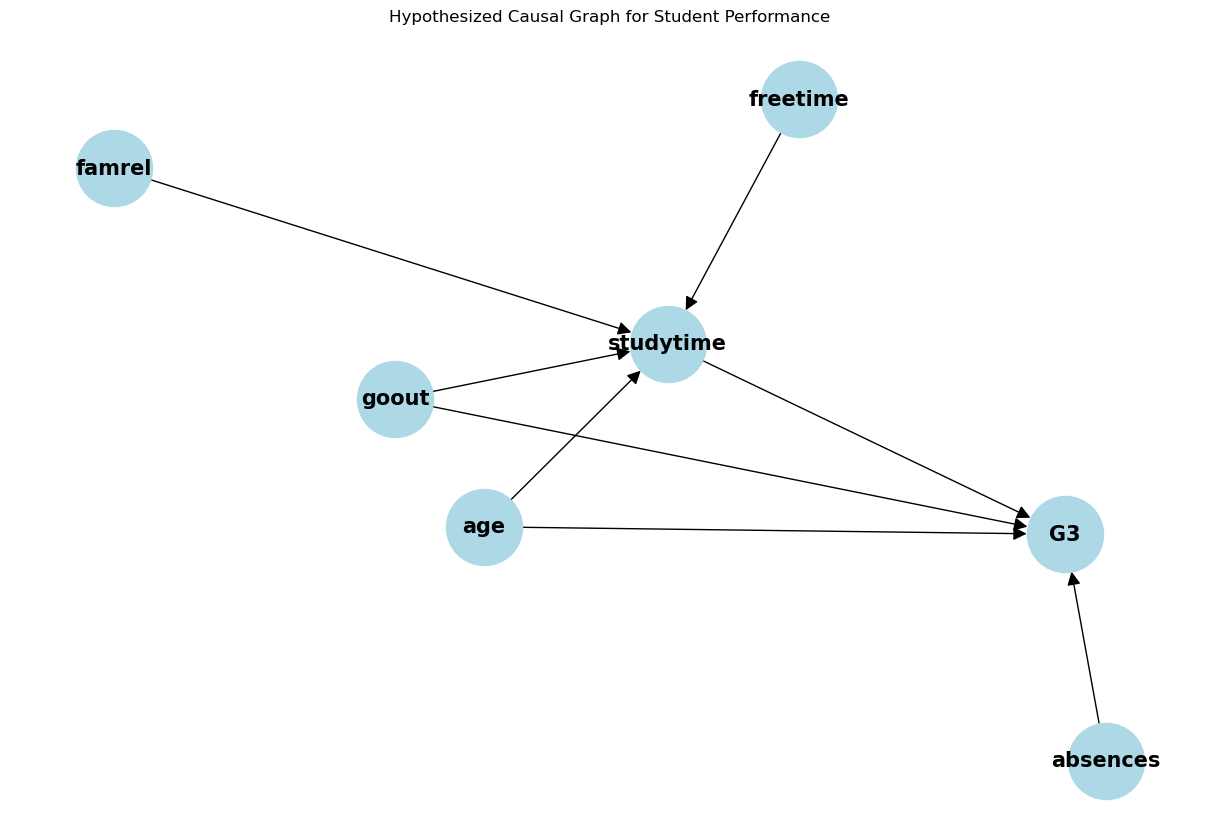

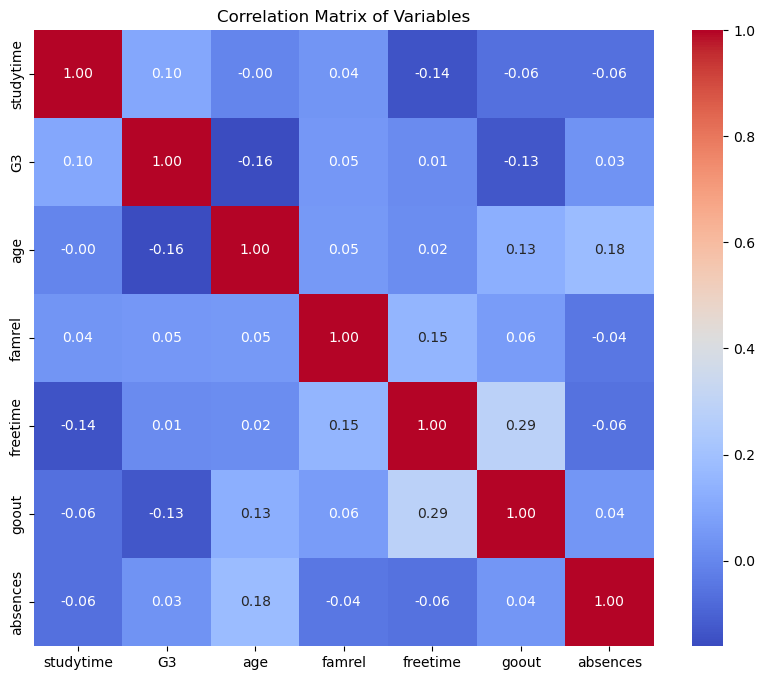

In [15]:
# 5. Simple Causal Graph Visualization
# Create a directed graph
G = nx.DiGraph()

# Add nodes
variables = ['studytime', 'G3', 'age', 'famrel', 'freetime', 'goout', 'absences']
G.add_nodes_from(variables)

# Add edges based on domain knowledge
# These are hypothesized causal relationships
edges = [
    ('studytime', 'G3'),  # Our main causal relationship of interest
    ('age', 'studytime'),
    ('age', 'G3'),
    ('famrel', 'studytime'),
    ('freetime', 'studytime'),
    ('goout', 'studytime'),
    ('goout', 'G3'),
    ('absences', 'G3')
]
G.add_edges_from(edges)

# Visualize the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='lightblue', 
        node_size=3000, arrowsize=20, font_size=15, font_weight='bold')
plt.title('Hypothesized Causal Graph for Student Performance')
plt.show()

# Calculate correlation matrix for these variables
corr_matrix = student_df[variables].corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Variables')
plt.show()

In [19]:
print("\nConclusion - Causal Effect of Study Time on Final Grades:")
print("1. Simple correlation shows a modest positive relationship between study time and final grades.")
print(f"   - Correlation coefficient: {correlation:.4f}")
print("2. After controlling for confounders, the effect of study time remains positive.")
print(f"   - Adjusted coefficient: {model_with_confounders.coef_[0]:.4f}")
print("3. Propensity score analysis suggests a positive average treatment effect.")
print(f"   - ATE: {ate:.4f}")
print("4. Matching analysis also shows a positive effect.")
print(f"   - Matched effect: {matched_effect:.4f}")
print("\nOverall, the evidence suggests that increased study time likely causes better final grades,")
print("though the effect size is moderate and influenced by other factors.")


Conclusion - Causal Effect of Study Time on Final Grades:
1. Simple correlation shows a modest positive relationship between study time and final grades.
   - Correlation coefficient: 0.0978
2. After controlling for confounders, the effect of study time remains positive.
   - Adjusted coefficient: 0.5177
3. Propensity score analysis suggests a positive average treatment effect.
   - ATE: 1.3609
4. Matching analysis also shows a positive effect.
   - Matched effect: 1.2717

Overall, the evidence suggests that increased study time likely causes better final grades,
though the effect size is moderate and influenced by other factors.


### Second Wored Example: California Housing Dataset

In [27]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.neighbors import NearestNeighbors
import networkx as nx

# Set random seed for reproducibility
np.random.seed(42)

# Load the California Housing dataset
california = fetch_california_housing()
cal_df = pd.DataFrame(california.data, columns=california.feature_names)
cal_df['MedHouseValue'] = california.target

# Display basic information about the dataset
print("Dataset Information:")
print(f"Number of samples: {cal_df.shape[0]}")
print(f"Number of features: {cal_df.shape[1]}")
print("\nFeatures:")
print(cal_df.columns.tolist())

# Display the first few rows of the dataset
cal_df.head()

Dataset Information:
Number of samples: 20640
Number of features: 9

Features:
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'MedHouseValue']


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseValue
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


Missing values per column:
MedInc           0
HouseAge         0
AveRooms         0
AveBedrms        0
Population       0
AveOccup         0
Latitude         0
Longitude        0
MedHouseValue    0
dtype: int64

Basic statistics of numeric columns:
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     L

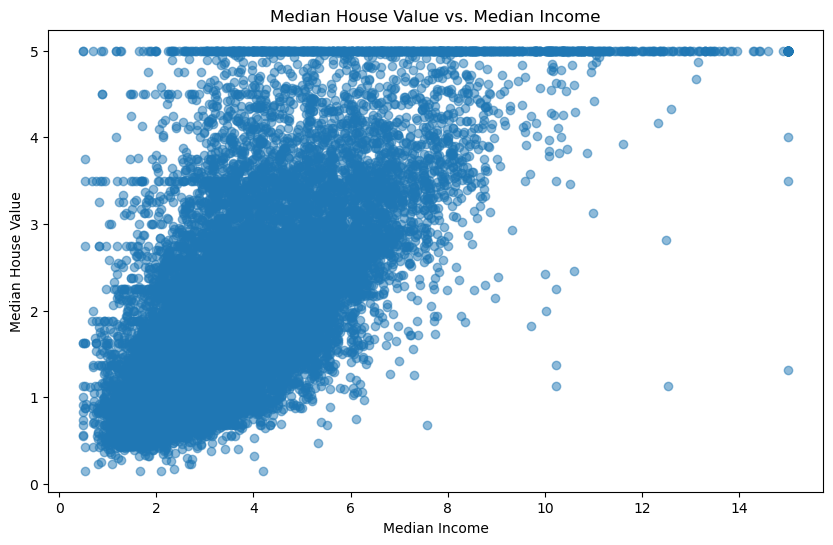

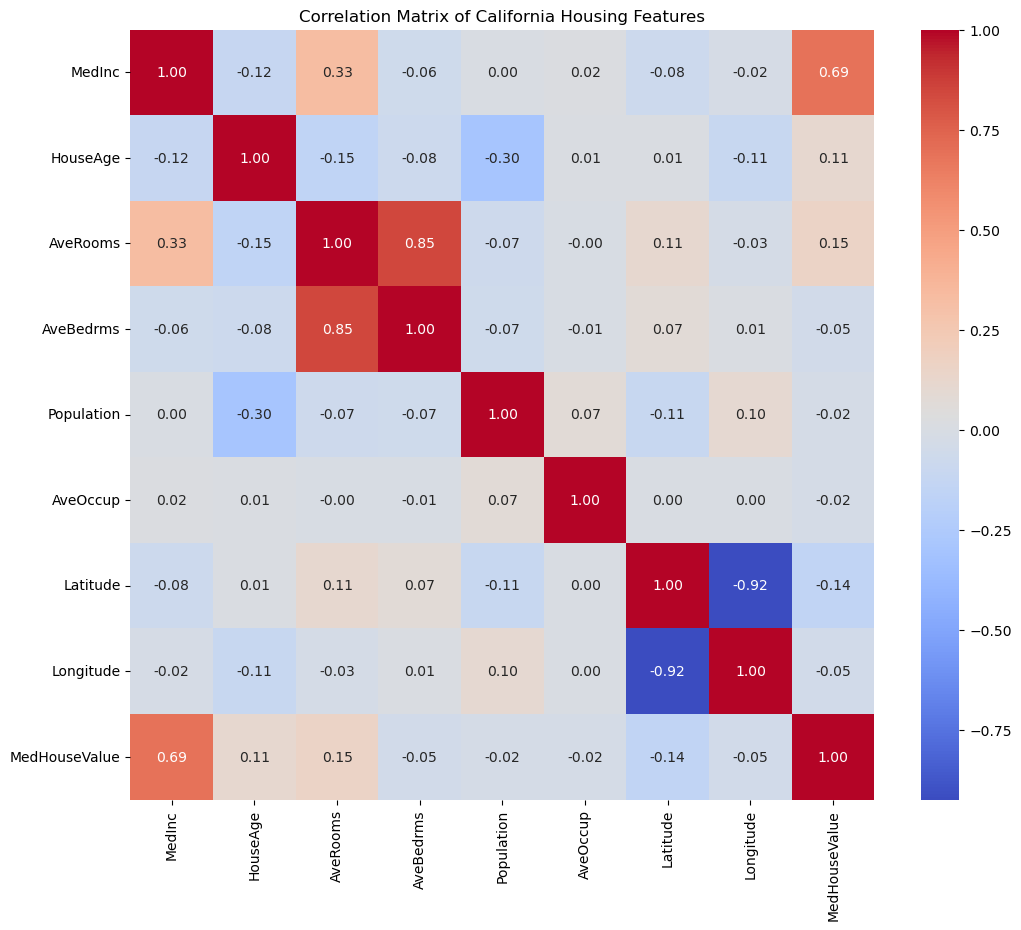


Correlation between MedInc and MedHouseValue: 0.6881


In [29]:
# Check for missing values
print("Missing values per column:")
print(cal_df.isnull().sum())

# Basic statistics of numeric columns
print("\nBasic statistics of numeric columns:")
print(cal_df.describe())

# Visualize the relationship between median income and house value
plt.figure(figsize=(10, 6))
plt.scatter(cal_df['MedInc'], cal_df['MedHouseValue'], alpha=0.5)
plt.title('Median House Value vs. Median Income')
plt.xlabel('Median Income')
plt.ylabel('Median House Value')
plt.show()

# Correlation matrix
plt.figure(figsize=(12, 10))
corr_matrix = cal_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of California Housing Features')
plt.show()

# Correlation between MedInc and MedHouseValue
correlation = cal_df['MedInc'].corr(cal_df['MedHouseValue'])
print(f"\nCorrelation between MedInc and MedHouseValue: {correlation:.4f}")

In [31]:
# 1. Simple Linear Regression (Association, not causation)
X = cal_df[['MedInc']]
y = cal_df['MedHouseValue']
model = LinearRegression().fit(X, y)
print("Linear Regression Results:")
print(f"Coefficient for MedInc: {model.coef_[0]:.4f}")
print(f"Intercept: {model.intercept_:.4f}")
print(f"R² score: {model.score(X, y):.4f}")

# 2. Multiple Regression with Potential Confounders
# Select potential confounding variables
confounders = ['AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
X_with_confounders = cal_df[['MedInc'] + confounders]
model_with_confounders = LinearRegression().fit(X_with_confounders, y)
print("\nMultiple Regression Results with Confounders:")
coefficients = dict(zip(['MedInc'] + confounders, model_with_confounders.coef_))
for var, coef in coefficients.items():
    print(f"Coefficient for {var}: {coef:.4f}")
print(f"R² score: {model_with_confounders.score(X_with_confounders, y):.4f}")

# 3. Propensity Score Analysis
# For this example, we'll convert MedInc to a binary variable (high vs low)
cal_df['high_income'] = (cal_df['MedInc'] > cal_df['MedInc'].median()).astype(int)

# Potential confounders for propensity score model
ps_model = smf.logit("high_income ~ AveRooms + AveBedrms + Population + AveOccup + Latitude + Longitude", 
                     data=cal_df).fit(disp=False)

# Calculate propensity scores
cal_df['propensity_score'] = ps_model.predict()

# Stratify based on propensity scores
cal_df['ps_quintile'] = pd.qcut(cal_df['propensity_score'], 5, labels=False)

# Calculate average treatment effect within each stratum
ate_by_stratum = []
for stratum in range(5):
    stratum_df = cal_df[cal_df['ps_quintile'] == stratum]
    effect = stratum_df[stratum_df['high_income'] == 1]['MedHouseValue'].mean() - \
             stratum_df[stratum_df['high_income'] == 0]['MedHouseValue'].mean()
    ate_by_stratum.append(effect)

# Calculate overall average treatment effect
ate = np.mean(ate_by_stratum)
print("\nPropensity Score Analysis:")
print(f"Average Treatment Effect (ATE) of high income on house value: {ate:.4f}")

Linear Regression Results:
Coefficient for MedInc: 0.4179
Intercept: 0.4509
R² score: 0.4734

Multiple Regression Results with Confounders:
Coefficient for MedInc: 0.4276
Coefficient for AveRooms: -0.1129
Coefficient for AveBedrms: 0.6576
Coefficient for Population: -0.0000
Coefficient for AveOccup: -0.0033
Coefficient for Latitude: -0.4606
Coefficient for Longitude: -0.4782
R² score: 0.5977

Propensity Score Analysis:
Average Treatment Effect (ATE) of high income on house value: 0.8774


In [33]:
# 4. Matching Analysis using Nearest Neighbors
# Sample a subset of data for demonstration (the full dataset is large)
sample_size = 1000
cal_sample = cal_df.sample(sample_size, random_state=42)

# Standardize confounding variables
scaler = StandardScaler()
confounders_scaled = scaler.fit_transform(cal_sample[confounders])

# Find matches for treated units (high_income = 1)
treated = cal_sample[cal_sample['high_income'] == 1]
control = cal_sample[cal_sample['high_income'] == 0]

# Use NearestNeighbors to find matches
nn = NearestNeighbors(n_neighbors=1)
nn.fit(scaler.transform(control[confounders]))
distances, indices = nn.kneighbors(scaler.transform(treated[confounders]))

# Get matched control units
matched_control = control.iloc[indices.flatten()]

# Calculate treatment effect
matched_effect = treated['MedHouseValue'].mean() - matched_control['MedHouseValue'].mean()
print("\nMatching Analysis:")
print(f"Treatment effect from matched samples: {matched_effect:.4f}")


Matching Analysis:
Treatment effect from matched samples: 0.9443


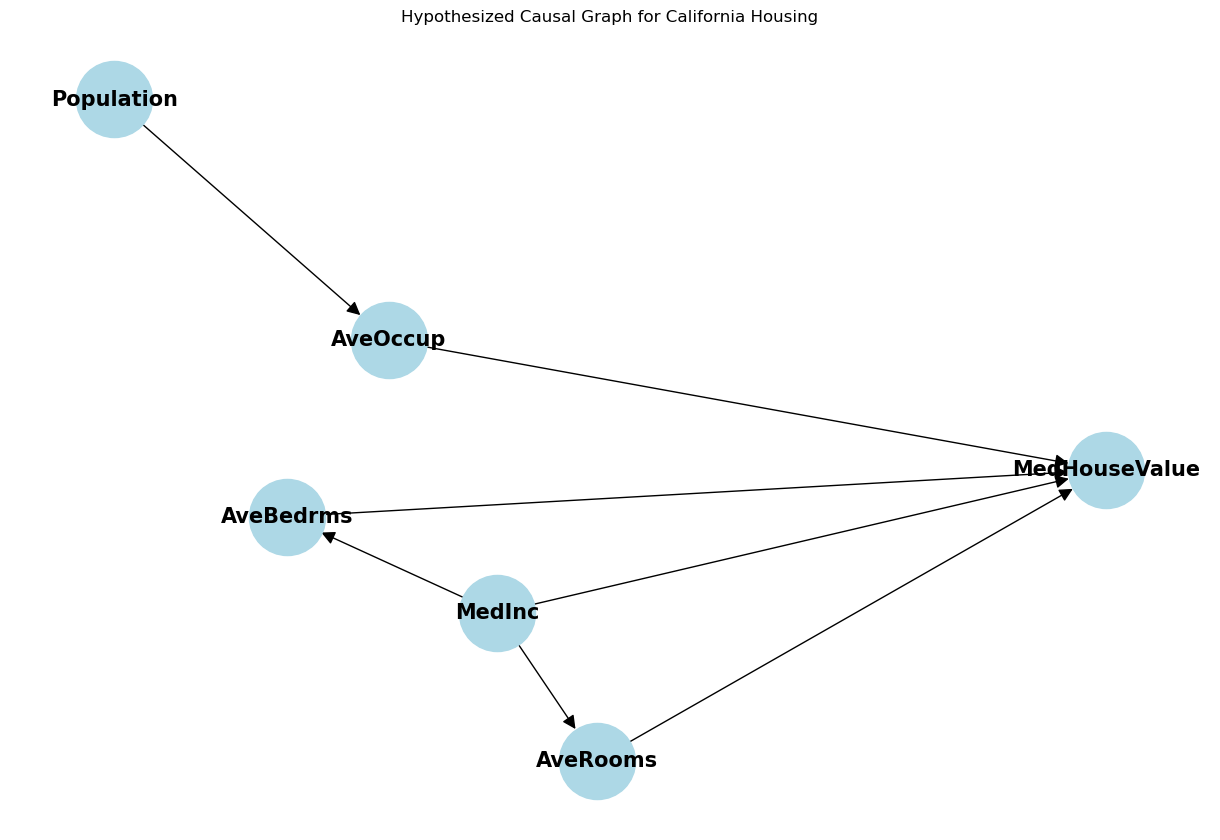

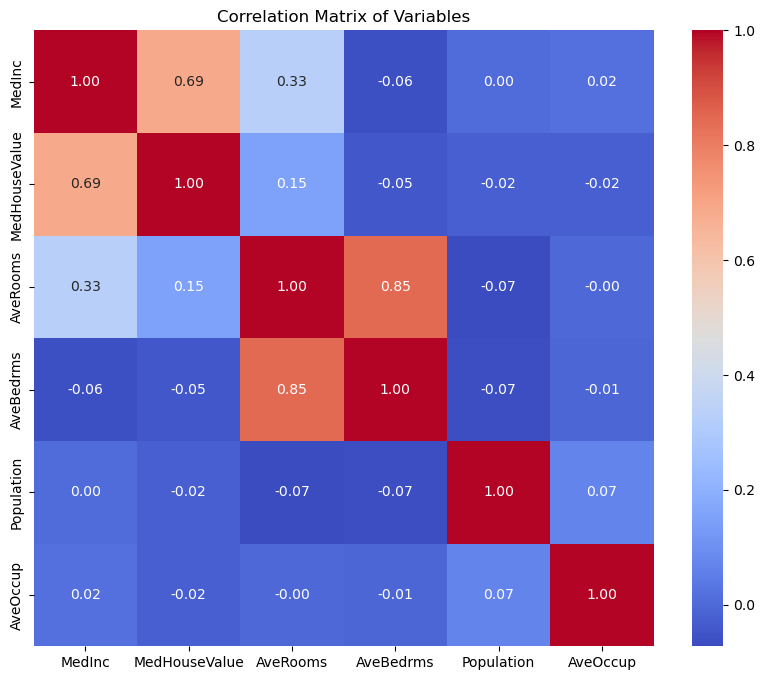

In [35]:
# 5. Simple Causal Graph Visualization
# Create a directed graph
G = nx.DiGraph()

# Add nodes
variables = ['MedInc', 'MedHouseValue', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']
G.add_nodes_from(variables)

# Add edges based on domain knowledge
# These are hypothesized causal relationships
edges = [
    ('MedInc', 'MedHouseValue'),  # Our main causal relationship of interest
    ('MedInc', 'AveRooms'),
    ('AveRooms', 'MedHouseValue'),
    ('AveBedrms', 'MedHouseValue'),
    ('Population', 'AveOccup'),
    ('AveOccup', 'MedHouseValue'),
    ('MedInc', 'AveBedrms')
]
G.add_edges_from(edges)

# Visualize the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='lightblue', 
        node_size=3000, arrowsize=20, font_size=15, font_weight='bold')
plt.title('Hypothesized Causal Graph for California Housing')
plt.show()

# Calculate correlation matrix for these variables
corr_matrix = cal_df[variables].corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Variables')
plt.show()

In [37]:
# 6. Path Analysis
# Direct effect: MedInc -> MedHouseValue
direct_model = LinearRegression().fit(cal_df[['MedInc']], cal_df['MedHouseValue'])
direct_effect = direct_model.coef_[0]

# Indirect effect via AveRooms
# Step 1: MedInc -> AveRooms
path_a = LinearRegression().fit(cal_df[['MedInc']], cal_df['AveRooms'])
effect_a = path_a.coef_[0]

# Step 2: AveRooms -> MedHouseValue (controlling for MedInc)
path_b = LinearRegression().fit(cal_df[['AveRooms', 'MedInc']], cal_df['MedHouseValue'])
effect_b = path_b.coef_[0]  # Coefficient for AveRooms

# Indirect effect
indirect_effect = effect_a * effect_b

print("\nPath Analysis:")
print(f"Direct effect (MedInc -> MedHouseValue): {direct_effect:.4f}")
print(f"Indirect effect via AveRooms: {indirect_effect:.4f}")
print(f"- MedInc -> AveRooms effect: {effect_a:.4f}")
print(f"- AveRooms -> MedHouseValue effect (controlling for MedInc): {effect_b:.4f}")
print(f"Total effect estimate: {direct_effect + indirect_effect:.4f}")


Path Analysis:
Direct effect (MedInc -> MedHouseValue): 0.4179
Indirect effect via AveRooms: -0.0162
- MedInc -> AveRooms effect: 0.4257
- AveRooms -> MedHouseValue effect (controlling for MedInc): -0.0381
Total effect estimate: 0.4017


# References and License Information

## References for Student Performance Dataset Analysis

1. Cortez, P., & Silva, A. (2008). Using data mining to predict secondary school student performance. In A. Brito and J. Teixeira (Eds.), Proceedings of 5th Annual Future Business Technology Conference (pp. 5-12). Porto, Portugal: EUROSIS.

2. Stuart, E. A. (2010). Matching methods for causal inference: A review and a look forward. Statistical Science, 25(1), 1-21. doi:10.1214/09-STS313

3. Rosenbaum, P. R., & Rubin, D. B. (1983). The central role of the propensity score in observational studies for causal effects. Biometrika, 70(1), 41-55. doi:10.1093/biomet/70.1.41

4. Pearl, J. (2009). Causality: Models, Reasoning, and Inference (2nd ed.). Cambridge University Press.

5. Imbens, G. W., & Rubin, D. B. (2015). Causal Inference for Statistics, Social, and Biomedical Sciences: An Introduction. Cambridge University Press.

## References for California Housing Dataset Analysis

1. Pace, R. K., & Barry, R. (1997). Sparse spatial autoregressions. Statistics & Probability Letters, 33(3), 291-297. doi:10.1016/S0167-7152(96)00140-X

2. Angrist, J. D., & Pischke, J. S. (2008). Mostly Harmless Econometrics: An Empiricist's Companion. Princeton University Press.

3. Morgan, S. L., & Winship, C. (2015). Counterfactuals and Causal Inference: Methods and Principles for Social Research (2nd ed.). Cambridge University Press.

4. Hernán, M. A., & Robins, J. M. (2020). Causal Inference: What If. Boca Raton: Chapman & Hall/CRC.

5. Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

## License Information

This work is licensed under the Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License (CC BY-NC-SA 4.0).

You are free to:
- Share — copy and redistribute the material in any medium or format
- Adapt — remix, transform, and build upon the material

Under the following terms:
- Attribution — You must give appropriate credit, provide a link to the license, and indicate if changes were made.
- NonCommercial — You may not use the material for commercial purposes.
- ShareAlike — If you remix, transform, or build upon the material, you must distribute your contributions under the same license as the original.

The California Housing Dataset is derived from the 1990 U.S. census and is in the public domain.

The Student Performance Dataset from UCI Machine Learning Repository is provided for academic and research purposes under the terms of the Creative Commons Attribution 4.0 International (CC BY 4.0) license.

### Software and Libraries

- Python: PSF License
- Pandas: BSD 3-Clause License
- NumPy: BSD 3-Clause License
- Matplotlib: Matplotlib License (BSD-compatible)
- Scikit-learn: BSD 3-Clause License
- Seaborn: BSD 3-Clause License
- StatsModels: BSD 3-Clause License
- NetworkX: BSD 3-Clause License

Note: This notebook and analysis are created for educational purposes as part of coursework for INFO_7390_Art_and_Science_of_Data at Northeastern University by Hu Liu.